In [34]:
# Ref http://imonad.com/rbm/restricted-boltzmann-machine/

In [ ]:
'''


'''

In [3]:
from numpy import *
from numpy.random import *
import pylab as p
from scipy import stats, mgrid, c_, reshape, random, rot90

In [17]:
class RBM:
    def __init__(self, nvis, nhid):
        self.sig = 0.2
        self.epsW = 0.5
        self.epsA  = 0.5
        self.nvis = nvis
        self.nhid = nhid
        self.Ndat = 500
        self.cost = 0.00001
        self.moment = 0.90
        self.Svis0 = zeros( nvis+1, dtype=float32)
        self.Svis0[-1] = 1.0
        self.Svis = zeros( nvis+1, dtype=float32)
        self.Svis[-1] = 1.0
        self.Shid = zeros( nhid+1, dtype=float32)
        self.W  = standard_normal((nvis+1, nhid+1))/10
        self.dW = standard_normal((nvis+1, nhid+1))/1000
        self.Avis  =  0.1*ones( nvis+1, dtype=float32)
        self.Ahid  =  ones( nhid+1, dtype=float32)
        self.dA = zeros( nvis+1, dtype=float32)
        self.dat = self.genData()

    def genData(self):
        c1 = 0.5
        r1 = 0.4
        r2 = 0.3
        # generate enough data to filter
        N = 20* self.Ndat
        X = array(random_sample(N))
        Y = array(random_sample(N))
        X1 = X[(X-c1)*(X-c1) + (Y-c1)*(Y-c1) < r1*r1]
        Y1 = Y[(X-c1)*(X-c1) + (Y-c1)*(Y-c1) < r1*r1]
        X2 = X1[(X1-c1)*(X1-c1) + (Y1-c1)*(Y1-c1) > r2*r2]
        Y2 = Y1[(X1-c1)*(X1-c1) + (Y1-c1)*(Y1-c1) > r2*r2]
        X3 = X2[ abs(X2-Y2)>0.05 ]
        Y3 = Y2[ abs(X2-Y2)>0.05 ]
        #X3 = X2[ X2-Y2>0.15 ]
        #Y3 = Y2[ X2-Y2>0.15]
        X4=zeros( self.Ndat, dtype=float32)
        Y4=zeros( self.Ndat, dtype=float32)
        for i in range(self.Ndat):
            if (X3[i]-Y3[i]) >0.05:
                X4[i] = X3[i] + 0.08
                Y4[i] = Y3[i] + 0.18
            else:
                X4[i] = X3[i] - 0.08
                Y4[i] = Y3[i] - 0.18
        print("X", size(X3[0:self.Ndat]), "Y", size(Y3))
        return(vstack((X4[0:self.Ndat],Y4[0:self.Ndat])))

    # Sigmoidal Function
    def sigFun(self, X, A):
        lo = 0.0
        hi = 1.0
        return(lo + (hi-lo)/(1.0 + exp(-A*X)))

    # visible=0, hidden=1
    def activ(self, who):
        if(who==0):
            self.Svis = dot(self.W, self.Shid) + self.sig*standard_normal(self.nvis+1)         
            self.Svis = self.sigFun(self.Svis, self.Avis)
            self.Svis[-1] = 1.0 # bias
        if(who==1):
            self.Shid = dot(self.Svis, self.W) + self.sig*standard_normal(self.nhid+1)
            self.Shid = self.sigFun(self.Shid, self.Ahid)
            self.Shid[-1] = 1.0 # bias

    def wview(self):
        import pylab as p
        p.plot(range(size(self.W[2])),self.W[2], 'bo')
        p.show()

    def learn(self, epochmax):
        Err = zeros( epochmax, dtype=float32)
        E = zeros( epochmax, dtype=float32)
        self.stat = zeros( epochmax, dtype=float32)
        self.stat2 = zeros( epochmax, dtype=float32)
        ksteps = 1
        
        for epoch in range(1,epochmax):
            wpos = zeros( (self.nvis+1, self.nhid+1), dtype=float32)
            wneg = zeros( (self.nvis+1, self.nhid+1), dtype=float32)
            apos = zeros( self.nhid+1, dtype=float32)
            aneg = zeros( self.nhid+1, dtype=float32)
                
            if(epoch>0):
                ksteps=50
            if(epoch>1000):
                ksteps=(epoch-epoch%100)/100+40
            self.ksteps = ksteps
            
            for point in range(self.Ndat):
                #print(self.dat[:][point])
                self.Svis0[0:2] = self.dat[:,point]
                self.Svis = self.Svis0
                # positive phase
                self.activ(1)
                wpos = wpos + outer(self.Svis, self.Shid)
                apos = apos + self.Shid*self.Shid
                # negative phase
                self.activ(0)
                self.activ(1)
                
                
                for recstep in range(ksteps): 
                    self.activ(0)
                    self.activ(1)

                tmp = outer(self.Svis, self.Shid)
                wneg = wneg + tmp
                aneg = aneg + self.Shid*self.Shid
                
                
                delta = self.Svis0[0:2]-self.Svis[0:2]
                # statistics
                Err[epoch] = Err[epoch] + sum(delta*delta)
                E[epoch] =E[epoch] -sum( dot(self.W.T, tmp) )
                

            
            self.dW = self.dW*self.moment + self.epsW * ((wpos-wneg)/size(self.dat) - self.cost*self.W)
            self.W = self.W + self.dW
            self.Ahid = self.Ahid + self.epsA*(apos-aneg)/(size(self.dat)*self.Ahid*self.Ahid)

            Err[epoch] = Err[epoch]/(self.nvis*size(self.dat))
            E[epoch] = E[epoch]/size(self.dat)
            if (epoch%100==0) or (epoch==epochmax) or (epoch==1):
                print("epoch:", epoch, "err:", round_(Err[epoch], 6), "ksteps:", ksteps)
            self.stat[epoch] = self.W[0,0]
            self.stat2[epoch] = self.Ahid[0]
        self.Err = Err
        self.E   = E
        

    def reconstruct(self, Npoint, Nsteps):
        X = array(random_sample(Npoint))
        Y = array(random_sample(Npoint))
        datnew = vstack((X, Y))
        self.datout = zeros( (2,Npoint), dtype=float32)
        for point in range(Npoint):
            self.Svis[0:2] = datnew[:,point]
            for recstep in range(Nsteps): 
                self.activ(1)
                self.activ(0)
        
            self.datout[:,point] = self.Svis[0:2]
            
    def contour(self, p, dat):
        X, Y = mgrid[0.0:1.0:100j, 0.0:1.0:100j]
        positions = c_[X.ravel(), Y.ravel()]
        val           = c_[dat[0,:], dat[1,:]]
        kernel = stats.kde.gaussian_kde(val.T)
        Z = reshape(kernel(positions.T).T, X.T.shape)
        p.imshow(     rot90(Z) , cmap=p.cm.YlGnBu, extent=[0, 1, 0, 1])
        p.plot(dat[0,:], dat[1,:], 'r.')
        p.axis([0.0, 1.0, 0.0, 1.0])

In [18]:
seed(12345)

In [19]:
rbm = RBM(2,8)

X 500 Y 2055


In [23]:
rbm.learn(1000)

epoch: 1 err: 0.009474 ksteps: 50
epoch: 100 err: 0.007771 ksteps: 50
epoch: 200 err: 0.006357 ksteps: 50
epoch: 300 err: 0.002823 ksteps: 50
epoch: 400 err: 0.002969 ksteps: 50
epoch: 500 err: 0.003105 ksteps: 50
epoch: 600 err: 0.003316 ksteps: 50
epoch: 700 err: 0.003244 ksteps: 50
epoch: 800 err: 0.003342 ksteps: 50
epoch: 900 err: 0.003223 ksteps: 50


In [24]:
kkk=0

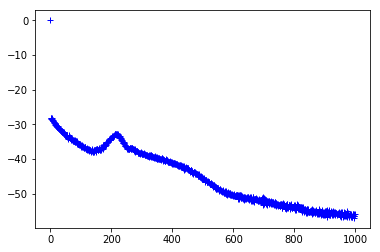

In [25]:
p.figure(1)
p.plot(range(size(rbm.E)), rbm.E, 'b+')

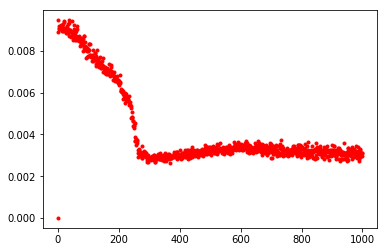

In [26]:
p.figure(2)
p.plot(range(size(rbm.Err)),rbm.Err, 'r.')

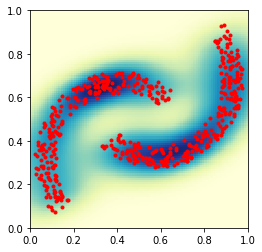

In [27]:
p.figure(3)
if kkk==1:
    p.plot(rbm.dat[0,:],rbm.dat[1,:], 'bo')
    p.axis([0.0, 1.0, 0.0, 1.0])
else:
    rbm.contour(p, rbm.dat)
    p.savefig("dat.png",dpi=100)

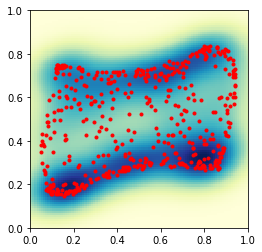

In [28]:
rbm.reconstruct(rbm.Ndat, 1)

p.figure(4)
if kkk==1:
    p.plot(rbm.datout[0,:],rbm.datout[1,:], 'b.')
    p.axis([0.0, 1.0, 0.0, 1.0])
else:
    rbm.contour(p, rbm.datout) 

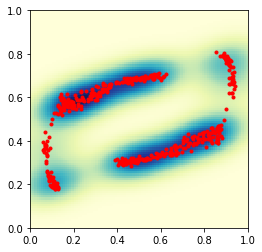

In [29]:
rbm.reconstruct(rbm.Ndat, 20)

p.figure(5)
if kkk==1:
    p.plot(rbm.datout[0,:],rbm.datout[1,:], 'b.')
    p.axis([0.0, 1.0, 0.0, 1.0])
else:
    rbm.contour(p, rbm.datout)

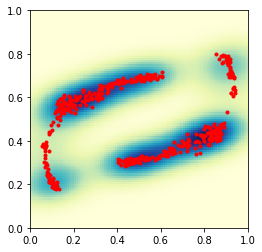

In [30]:
rbm.reconstruct(rbm.Ndat, rbm.ksteps)

p.figure(6)
if kkk==1:
    p.plot(rbm.datout[0,:],rbm.datout[1,:], 'b.')
    p.axis([0.0, 1.0, 0.0, 1.0])
else:
    rbm.contour(p, rbm.datout)
    p.savefig("reconstruct.png",dpi=100)

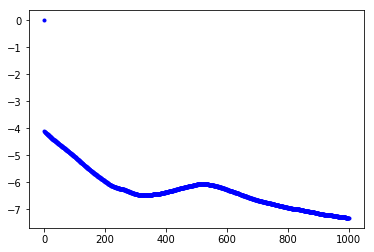

In [31]:
p.figure(7)

p.plot(range(size(rbm.stat)), rbm.stat, "b.")

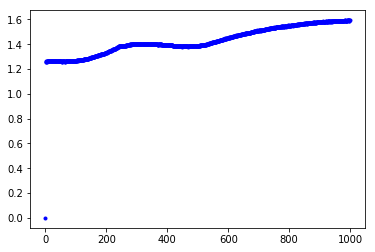

In [32]:
p.figure(8)
p.plot(range(size(rbm.stat2)), rbm.stat2, "b.")

In [33]:
print(around(rbm.W,5))
print(rbm.Ahid)
p.show()

[[ -7.31742   7.92019  -9.09414 -10.64808  12.26461  11.24614  -5.33945
   -3.49119   0.67488]
 [ -0.97197   1.79705  -6.61831   2.27888  -3.55034   8.07475   9.42206
   -8.45038  -1.18032]
 [  4.31541  -4.65154  12.01372   7.78447   0.0168   -4.44921  -1.94359
    6.00368   0.03701]]
[1.59168438 0.78955747 2.0348075  1.7446028  1.20446627 1.29294831
 1.67926618 1.44896617 1.        ]
